## Falling Tablecloth

- Ising
    - Simulated Annealing
        - Optimization problem
    - Probability Dist. Sampling
        - Sampling from a probability graph
- Cloth
    - equally spaced points
    - eeach point has a madd and connected to NN via a spring

    O-*-O-*-O-*-O

    each sping has a spring contact K
    F=-l delta X
    (x,y,z) positioning
    Spring has a equal librium length
    F= mg    - force of gravity at work

dE = -1/2 k (sum)i=nn [(d'_i-l)**2- (d_i-l)**2]+mg delta z

d'_i= | r' - r_i |   = distance from points if preterbed
d_i= | r - r_i |   = distance from points if not changed


Pick a random point to preterb
delta r = (delta x,delta y,delta z )
        gausian determined changes
r' = r+ delta r

d' is preterbed praticles neibours

- DO not pick corners for perterbation
- Other edge chases only check 3 NN


In [135]:
import numpy as np


class cloth:
    def __init__(self,n,kT):
        self.n =n
        self.k=50
        self.l=1
        self.m=.05
        self.sigma =  .25*self.l

        self.kT = kT
        self.g=9.8
        self.E=0
        self.step = 0
        self.lattice = {}
        self.build_lattice()

        self.blacklist = [[0,0],[0,self.n-1],[self.n-1,0],[self.n-1,self.n-1]]
        self.E_data=[]
        self.tolerance_counter =0

    def build_lattice(self):

        for i in range(self.n):
            for j in range(self.n):
                self.lattice[(i,j)]=np.array([i*self.l,j*self.l,10],dtype=np.float64)

    def set_black_list(self):
        pass


    def perturbation(self):
        sigma = .25
        dx=dy=dz=0
        p = np.random.rand()
        if p<.25:
            dx= np.random.randn() *sigma
        elif p<.5:
            dy = np.random.randn() *sigma
        else:
            dz = np.random.randn() *sigma
        point = self.select_point()
        dE = self.delta_Energy(point,[dx,dy,dz])
        return dE, point ,np.array([dx,dy,dz])

    def select_point(self):
        x=y=0

        while [x,y] in self.blacklist:
            x = np.random.randint(0,self.n)
            y = np.random.randint(0,self.n)
        return [x,y]

    def delta_Energy(self,point,dr):


        sum= 0

        nn = [(point[0]-1,point[1]),
              (point[0]+1,point[1]),
              (point[0],point[1]-1),
              (point[0],point[1]+1)]

        for n in nn:
            if n in self.lattice:
                nr = self.lattice[n]
                r = self.lattice[(point[0],point[1])]
                rp = self.lattice[(point[0],point[1])] + dr

                term1 = (np.linalg.norm(rp-nr)-self.l)**2
                term2 = (np.linalg.norm(r-nr)-self.l)**2
                sum += term1-term2
                # print("Term 1 {} Term 2 {} Sum {} ".format(term1,term2,sum))
        sum *= self.k/2
        sum += self.g*self.m*dr[2]

        return sum

    def do_mcmc_step(self,Flag):

        for i in range(self.n*self.n):
            dE,pt,dR=self.perturbation()

            if dE<0 or np.random.rand() < np.exp(-dE/self.kT):
                for i in range(3):
                    self.lattice[tuple(pt)][i] = self.lattice[tuple(pt)][i]+dR[i]
                self.E+= dE

        self.step += 1
        self.E_data.append(self.E/(self.step*self.n*self.n))
        if self.step>500 and Flag:
            self.tolerance()

    def get_data(self):
        xdata = np.zeros((self.n,self.n),dtype=np.float64)
        ydata = np.zeros((self.n,self.n),dtype=np.float64)
        zdata = np.zeros((self.n,self.n),dtype=np.float64)
        for point in self.lattice:
            x,y = point
            xdata[x][y]=self.lattice[point][0]
            ydata[x][y]=self.lattice[point][1]
            zdata[x][y]=self.lattice[point][2]
        return xdata,ydata,zdata
    # half the temp
    def update_temp(self):
        self.kT *= .5

    def tolerance(self):
        my_range = self.E_data[self.step-100:self.step]
        denom = my_range[0]-my_range[-1]
        detal_en = my_range[-50]-my_range[-51]
        # if self.step %100==0:

            # print("Counter ",self.step,detal_en/denom)
        if abs(detal_en/denom) <.0065:
            # print(self.step,detal_en/denom)
            self.tolerance_counter +=1
            self.update_temp()


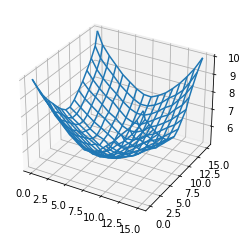

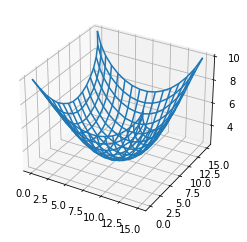

In [136]:
from mpl_toolkits.mplot3d import axes3d

import matplotlib.pyplot as plt

def myplot(n,temp,flag):

    app = cloth(n,temp)
    while app.step<10000:
        app.do_mcmc_step(flag)
        if app.tolerance_counter>2:
            # print("Done?",app.step)
            break
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Grab some test data.
    x,y,z = app.get_data()
    # average termination over 500 mcmc steps
    # Plot a basic wireframe.

    ax.plot_wireframe(x,y,z, ccount=n, rcount=n )
    # ax = fig.add_subplot(212)
    # energy = app.E_data
    # x = range(len(energy))
    # ax.plot(x,energy)
    plt.show()
myplot(16,1e-3,True)
myplot(16,1e-3,False)

#### Problem Statement
Simulate the hanging tablecloth problem, and find the minimum energy by thermal relaxation. Assume that each of the four corners of the cloth are fixed at the same $z$ for the entire simulation and that the cloth is square.

a) Design a Metropolis updater using the formula above to find $\Delta E$. Monitor the energy as a function of MCMC steps. Assume the initial energy is zero, and keep track of total energy by summing the accepted $\Delta E$s. The shape of this curve should be evaluated to find when the function is minimized.

Convergence can be improved by selecting only a single direction to perturb in, and sampling more frequently in the $z$ direction, where potential energy can have a large impact on $\Delta E$. So, 25% of the time perturb in the $x$ direction, 25% in the $y$, and 50% in the $z$. The perturbations are going to be in space, and some normal distribution is the right choice. Let's increase the perturbation distribution by a factor of two in the $z$ direction so it is explored more aggressively. Something like the following in code:

Run the simulation to equilibrium and plot the result. Try the `plot_wireframe` function. Begin with all positions of masses seperated by $l$ from nearest neighbors, and having the same $z$ coordinate.

How did you determine the system was in equilibrium? Add this function to your code.
### Equal librium was reached when the change within a 100 steps range was less than .65%
Repeat the experiment, but now include a ''cooling schedule''. Try halving the temperature each time the system reaches equilibrium. Do three successive halvings. Plot the different final configurations and comment on their differences.

(b) Plot the energy per particle vs the temperature at various lattice sizes. Explain what you find.
### You can see with the larger lattice sizes that the system slower to reach equilibrium  and that the equilibrium has a small amount of  more energy per particle

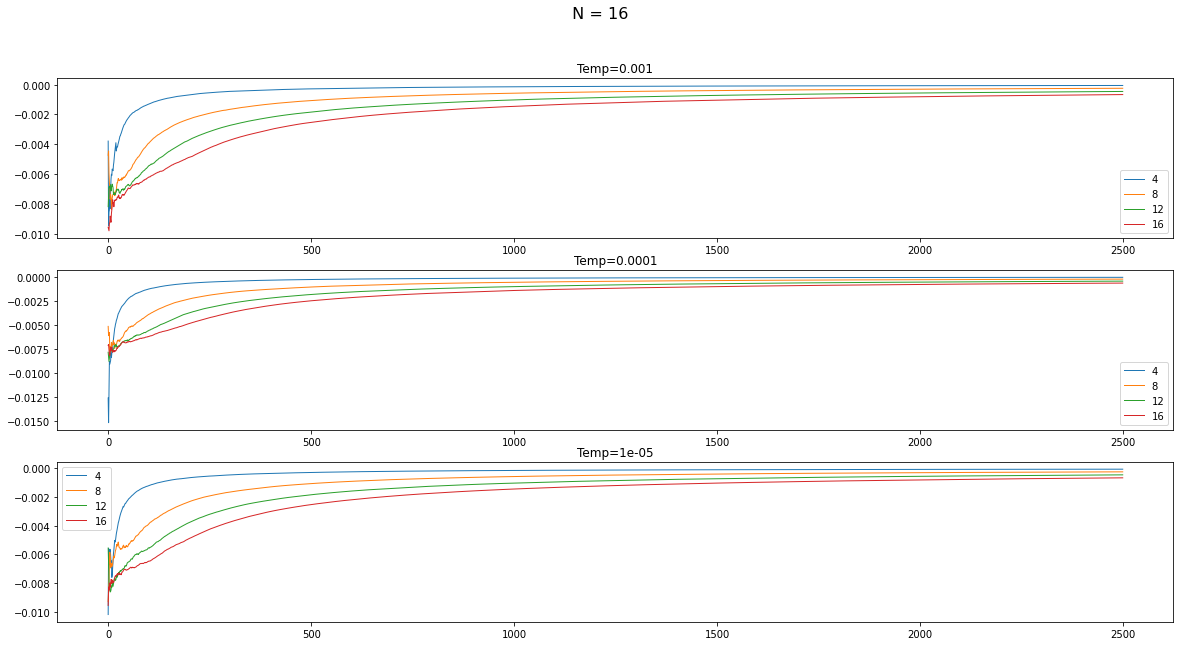

In [137]:
def temp_energy():

    fig, ax = plt.subplots(3,figsize=(20, 10))
    for n in range(4,17,4):

        for i in range(3):
            temp = 1/10**(i+3)
            app = cloth(n,temp)
            while app.step<2500:
                app.do_mcmc_step(False)
            E=app.E_data
            x_data = range(len(E))
            fig.suptitle(" N = {}".format(n), fontsize=16)
            ax[i].set_title('Temp={}'.format(temp))
            ax[i].plot(x_data, E, lw=1,label=n)
            ax[i].legend()
    plt.show()
temp_energy()